In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import os

# Base path that can be modified according to the system
base_path = "/home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/"

def densenet(input_shape, n_classes, filters=32):
    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
        return x

    def dense_block(x, repetitions):
        for _ in range(repetitions):
            y = bn_rl_conv(x, 4 * filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y, x])
        return x

    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x

    input_layer = Input(input_shape)
    x = Conv2D(64, 3, strides=1, padding='same')(input_layer)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for repetitions in [6, 12, 24, 16]:
        d = dense_block(x, repetitions)
        x = transition_layer(d)
    
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Setup paths using the base path
data_dir = os.path.join(base_path, 'project_1_dataset/train')

# Data generators with augmentation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation')

# Create the model
model = densenet((48, 48, 1), 7)  # 7 classes
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

'''# Freeze the layers up to the third transition layer
transition_layer_count = 0
for layer in model.layers:
    if 'avg_pool' in layer.name:  # Assuming each transition layer includes AvgPool2D
        transition_layer_count += 1
    if transition_layer_count <= 3:
        layer.trainable = False'''

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_121 (Conv2D)         (None, 48, 48, 64)           640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)           0         ['conv2d_121[0][0]']          
 g2D)                                                                                             
                                                                                                  
 batch_

In [4]:
# Adjusting the batch size for the new training session
new_batch_size = 16  # New batch size for comparison

# Data generators with the new batch size
new_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

new_train_generator = new_datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=new_batch_size,  # Updated batch size
    color_mode='grayscale',
    class_mode='categorical',
    subset='training')

new_validation_generator = new_datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=new_batch_size,  # Keeping batch size consistent for validation
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation')

# Reusing the model architecture but creating a new instance for this training
new_model = densenet((48, 48, 1), 7)  # Same architecture, new instance
new_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the new model with the updated batch size
new_history = new_model.fit(new_train_generator, epochs=50, validation_data=new_validation_generator)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/50
1436/1436 [==============================] - 145s 71ms/step - loss: 1.8564 - accuracy: 0.2438 - val_loss: 1.9847 - val_accuracy: 0.2543
Epoch 2/50
1436/1436 [==============================] - 89s 62ms/step - loss: 1.7761 - accuracy: 0.2648 - val_loss: 5.5231 - val_accuracy: 0.1850
Epoch 3/50
1436/1436 [==============================] - 88s 61ms/step - loss: 1.7002 - accuracy: 0.3058 - val_loss: 1.8180 - val_accuracy: 0.2818
Epoch 4/50
1436/1436 [==============================] - 89s 62ms/step - loss: 1.5721 - accuracy: 0.3750 - val_loss: 3.2670 - val_accuracy: 0.3447
Epoch 5/50
1436/1436 [==============================] - 98s 68ms/step - loss: 1.4668 - accuracy: 0.4301 - val_loss: 1.4430 - val_accuracy: 0.4318
Epoch 6/50
1436/1436 [==============================] - 101s 70ms/step - loss: 1.3696 - accuracy: 0.4717 - val_loss: 1.3935 - val_accuracy: 0.4677
Epoch 7/50
1436/1436 [===============

In [ ]:
# Save the model
model_save_path = os.path.join(base_path, 'MODELS/ClusDense')
model_save_keras_path = os.path.join(base_path, 'MODELS/ClusDense.keras')
model.save(model_save_path)
model.save(model_save_keras_path, save_format='keras')

In [ ]:
# Save paths for the new_model
new_model_save_path = os.path.join(base_path, 'MODELS/NewClusDense')
new_model_save_keras_path = os.path.join(base_path, 'MODELS/NewClusDense.keras')

# Saving the new_model in TensorFlow SavedModel format
new_model.save(new_model_save_path)

# Saving the new_model in Keras HDF5 format
new_model.save(new_model_save_keras_path, save_format='keras')


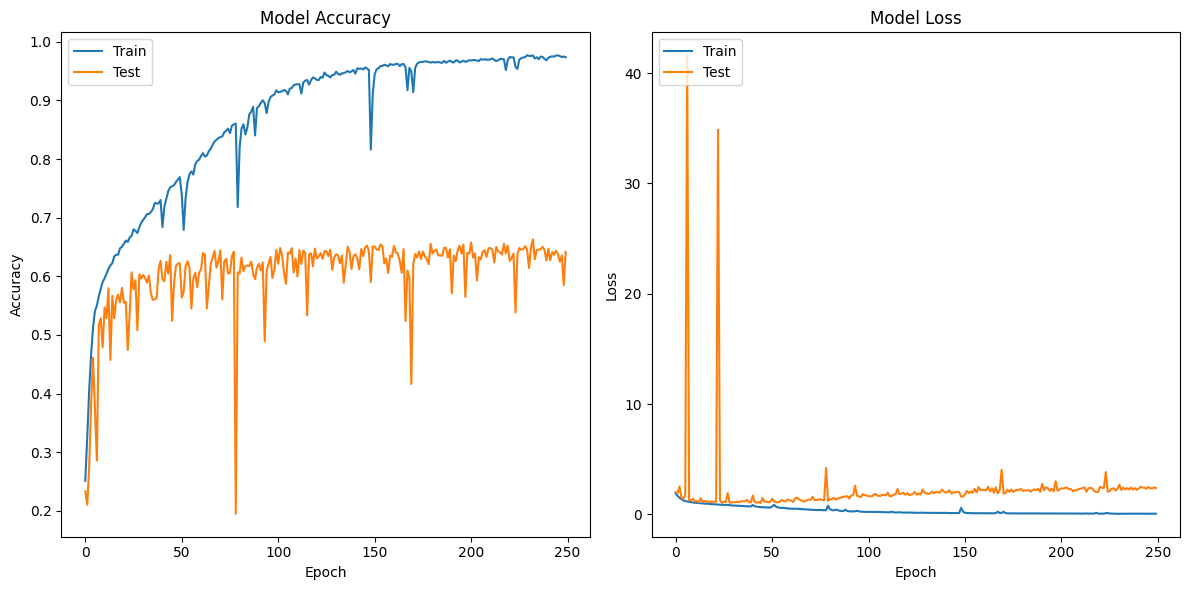

In [10]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

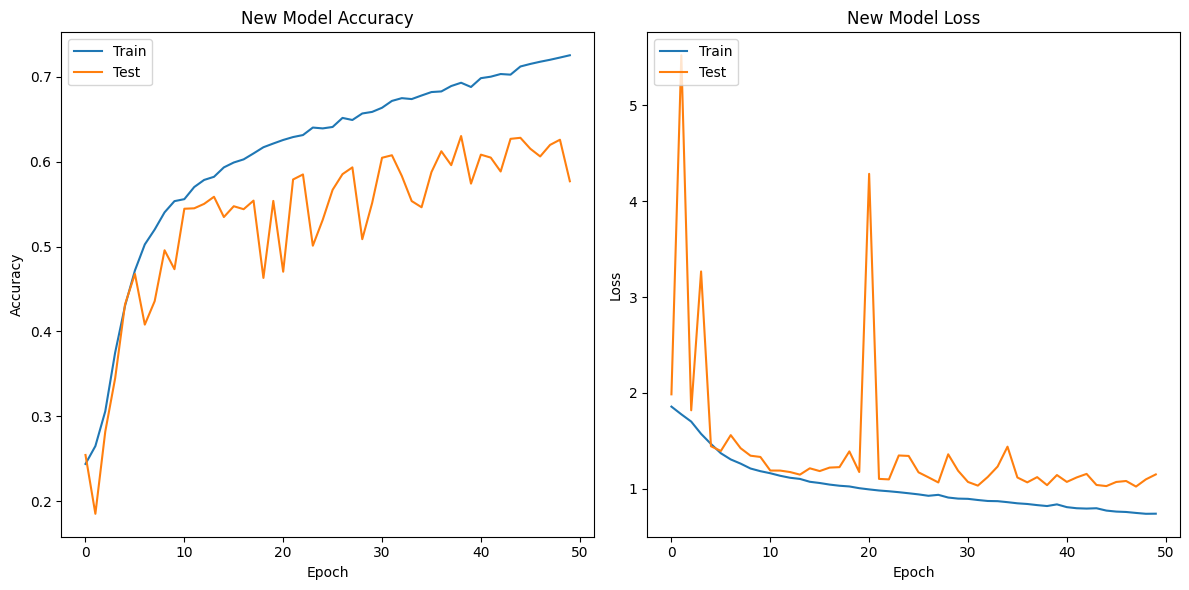

In [5]:
import matplotlib.pyplot as plt

# Summarize history for accuracy of the new model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('New Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Summarize history for loss of the new model
plt.subplot(1, 2, 2)
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('New Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()